**Data Source: Meta Trader 5** <br>
**USDJPY 5 Minute TimeFrame**

# Import Library

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TFT Model

/content/drive/MyDrive/TFT Model


In [ ]:
# Install darts library
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel

#warning
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("darts").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
# Silence PyTorch Lightning logs
pl_logger = logging.getLogger("pytorch_lightning")
pl_logger.setLevel(logging.WARNING)

In [ ]:
df_raw = pd.read_csv('USDJPY_2025.csv')
df = df_raw.copy()
# Gabungkan Date dan Time jadi datetime index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],format='%m/%d/%Y %I:%M:%S %p')
df.set_index('Datetime', inplace=True)
df = df[['Open', 'High', 'Low', 'Close', 'Tickvol', 'Spread']].copy()  # Keep only relevant columns

# Moving Average (MA20)
df['MA20'] = df['Close'].rolling(window=20).mean()

# Average True Range (ATR)
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR'] = true_range.rolling(window=14).mean()

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Stochastic Oscillator (fast %K and slow %D)
low14 = df['Low'].rolling(window=14).min()
high14 = df['High'].rolling(window=14).max()
df['%K'] = 100 * ((df['Close'] - low14) / (high14 - low14))
df['%D'] = df['%K'].rolling(window=3).mean()

# Supertrend calculation
def calculate_supertrend(df, period=10, multiplier=3):
    hl2 = (df['High'] + df['Low']) / 2
    atr = df['ATR']
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)

    supertrend = [True] * len(df)

    for i in range(1, len(df)):
        if df['Close'].iloc[i] > upperband.iloc[i - 1]:
            supertrend[i] = True
        elif df['Close'].iloc[i] < lowerband.iloc[i - 1]:
            supertrend[i] = False
        else:
            supertrend[i] = supertrend[i - 1]
            if supertrend[i] and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if not supertrend[i] and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

    df['Supertrend'] = supertrend
    return df

df = calculate_supertrend(df)

#future covariate

# Pastikan index datetime
df.index = pd.to_datetime(df.index)

def generate_nfp_hours_mt_timezone(start_year, end_year):
    nfp_hours = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            first_day = pd.Timestamp(f"{year}-{month:02d}-01")
            for i in range(7):
                day = first_day + pd.Timedelta(days=i)
                if day.weekday() == 4:  # Friday
                    # Round to 15:00 to match MetaTrader candle
                    nfp_hour = pd.Timestamp(f"{day.date()} 15:00:00")
                    nfp_hours.append(nfp_hour)
                    break
    return pd.Series(nfp_hours)

# missing value
df.index = pd.to_datetime(df.index)
df = df.asfreq("h")  # Set agar frekuensi waktu hourly dan konsisten

# Tangani missing value (jika ada)
df = df.fillna(method="ffill")  # atau bisa diinterpolasi
# Sesuaikan rentang tahun sesuai data kamu
nfp_hours_mt = generate_nfp_hours_mt_timezone(2024, 2025)
df['is_nfp'] = df.index.floor("H").isin(nfp_hours_mt).astype(int)

df['Supertrend'] = df['Supertrend'].astype(int)
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['is_market_open'] = (df['weekday'] < 5).astype(int)  # Monday–Friday only as in forex market only open thoes day

# Tampilkan beberapa baris pertama hasilnya
print(df[['Close', 'MA20', 'ATR', 'RSI', '%K', '%D', 'Supertrend']].head(25))

df.tail()

                       Close  MA20  ATR  RSI  %K  %D  Supertrend
Datetime                                                        
2025-01-01 00:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 01:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 02:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 03:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 04:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 05:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 06:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 07:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 08:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 09:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 10:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 11:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 12:00:00  157.061   NaN  NaN  NaN NaN NaN           1
2025-01-01 13:00:00  157.

,Open,High,Low,Close,Tickvol,Spread,MA20,ATR,RSI,%K,%D,Supertrend,is_nfp,hour,weekday,is_market_open
Datetime,,,,,,,,,,,,,,,,
2025-06-03 19:00:00,143.931,144.101,143.869,143.971,3522.0,13.0,143.07985,0.268429,77.267081,91.339107,91.694321,1,0,19,1,1
2025-06-03 20:00:00,143.970,144.021,143.830,143.838,2825.0,13.0,143.13925,0.264357,70.385757,82.478348,90.042384,1,0,20,1,1
2025-06-03 21:00:00,143.840,143.935,143.830,143.899,2617.0,13.0,143.20805,0.249857,81.396867,86.542305,86.786587,1,0,21,1,1
2025-06-03 22:00:00,143.899,144.098,143.889,144.064,2491.0,13.0,143.29035,0.246714,83.146067,97.534977,88.851877,1,0,22,1,1
2025-06-03 23:00:00,144.063,144.068,143.887,143.896,1264.0,13.0,143.35015,0.242000,78.416062,86.342438,90.139907,1,0,23,1,1


In [ ]:
print(df.index.freq)

<Hour>


In [ ]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Tickvol,0
Spread,0
MA20,42
ATR,36
RSI,36
%K,36


In [ ]:
df = df.dropna().copy()
df

,Open,High,Low,Close,Tickvol,Spread,MA20,ATR,RSI,%K,%D,Supertrend,is_nfp,hour,weekday,is_market_open
Datetime,,,,,,,,,,,,,,,,
2025-01-02 18:00:00,157.147,157.749,157.131,157.659,3816.0,4.0,157.12990,0.340500,56.850566,93.124523,69.021106,1,0,18,3,1
2025-01-02 19:00:00,157.659,157.848,157.489,157.564,3535.0,4.0,157.15505,0.354000,57.480606,79.829545,79.728063,1,0,19,3,1
2025-01-02 20:00:00,157.563,157.630,157.464,157.499,2955.0,4.0,157.16710,0.354286,59.073652,75.213068,82.722379,1,0,20,3,1
2025-01-02 21:00:00,157.498,157.671,157.475,157.618,2471.0,3.0,157.16310,0.351857,58.021807,83.664773,79.569129,1,0,21,3,1
2025-01-02 22:00:00,157.617,157.654,157.566,157.627,2182.0,4.0,157.17290,0.318786,73.806007,84.303977,81.060606,1,0,22,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03 19:00:00,143.931,144.101,143.869,143.971,3522.0,13.0,143.07985,0.268429,77.267081,91.339107,91.694321,1,0,19,1,1
2025-06-03 20:00:00,143.970,144.021,143.830,143.838,2825.0,13.0,143.13925,0.264357,70.385757,82.478348,90.042384,1,0,20,1,1
2025-06-03 21:00:00,143.840,143.935,143.830,143.899,2617.0,13.0,143.20805,0.249857,81.396867,86.542305,86.786587,1,0,21,1,1


In [ ]:
# Show Non-Farm Payroll (NFP) date release
df[df['is_nfp'] == 1]

,Open,High,Low,Close,Tickvol,Spread,MA20,ATR,RSI,%K,%D,Supertrend,is_nfp,hour,weekday,is_market_open
Datetime,,,,,,,,,,,,,,,,
2025-01-03 15:00:00,157.162,157.239,157.023,157.185,2839.0,4.0,157.32675,0.201071,42.265193,37.241379,33.151707,1,1,15,4,1
2025-02-07 15:00:00,152.008,152.413,151.297,151.953,4510.0,3.0,151.65430,0.303786,77.896233,68.363136,82.484912,1,1,15,4,1
2025-03-07 15:00:00,147.734,147.966,147.115,147.225,5298.0,3.0,147.68345,0.349357,29.912664,10.536398,39.631952,0,1,15,4,1
2025-04-04 15:00:00,145.371,145.637,145.017,145.594,10962.0,13.0,145.93650,0.570500,49.659266,52.731830,33.469592,0,1,15,4,1
2025-05-02 15:00:00,144.550,144.952,144.330,144.633,7799.0,13.0,145.20660,0.347500,36.178700,19.165085,15.634407,0,1,15,4,1


In [ ]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2025-01-02 18:00:00 to 2025-06-03 23:00:00
Freq: h
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            3654 non-null   float64
 1   High            3654 non-null   float64
 2   Low             3654 non-null   float64
 3   Close           3654 non-null   float64
 4   Tickvol         3654 non-null   float64
 5   Spread          3654 non-null   float64
 6   MA20            3654 non-null   float64
 7   ATR             3654 non-null   float64
 8   RSI             3654 non-null   float64
 9   %K              3654 non-null   float64
 10  %D              3654 non-null   float64
 11  Supertrend      3654 non-null   int64  
 12  is_nfp          3654 non-null   int64  
 13  hour            3654 non-null   int32  
 14  weekday         3654 non-null   int32  
 15  is_market_open  3654 non-null   int64  
dtypes: float64(11), int32(2), int64(3)

In [ ]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Tickvol,0
Spread,0
MA20,0
ATR,0
RSI,0
%K,0


# Exploratory Data Analysis

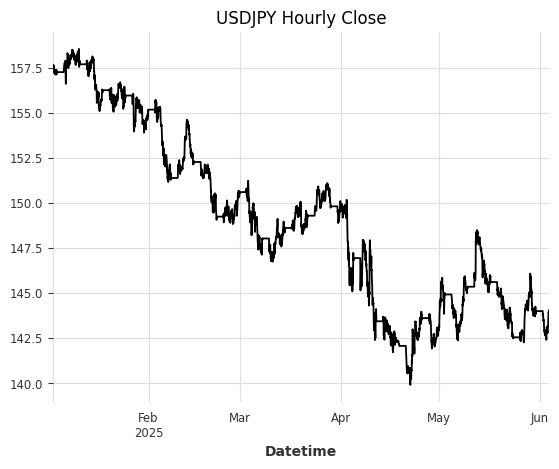

In [ ]:
# Plot the hourly price of usdjpy
df['Close'].plot(title = 'USDJPY Hourly Close')
plt.show()

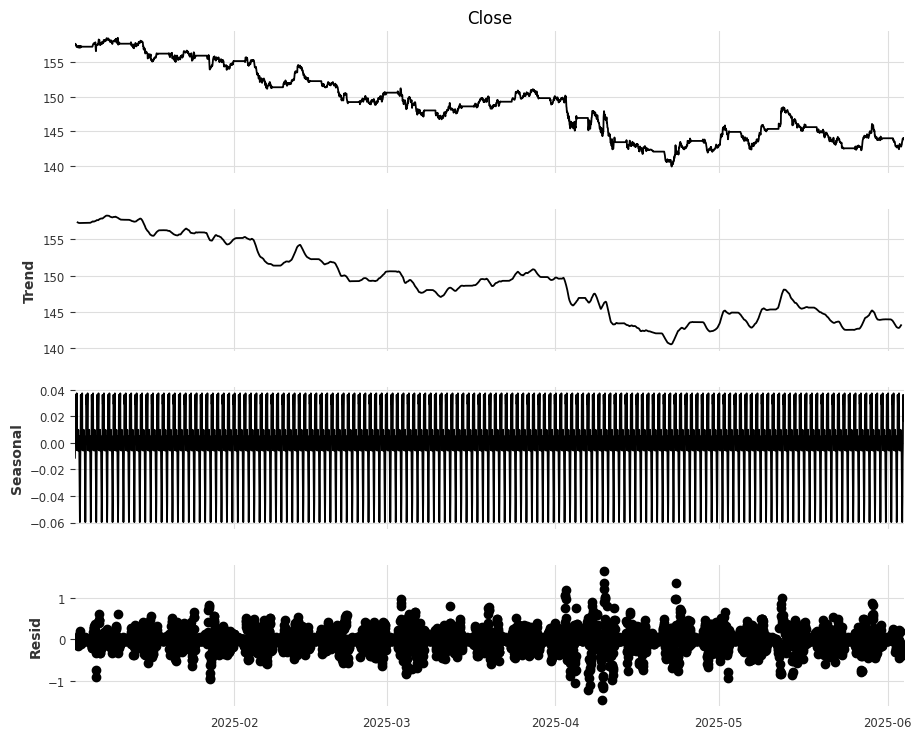

In [ ]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Close'],
                                   model = 'add',
                                   period = 24)

# Plot the decomposed components (trend, seasonal, and residual)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

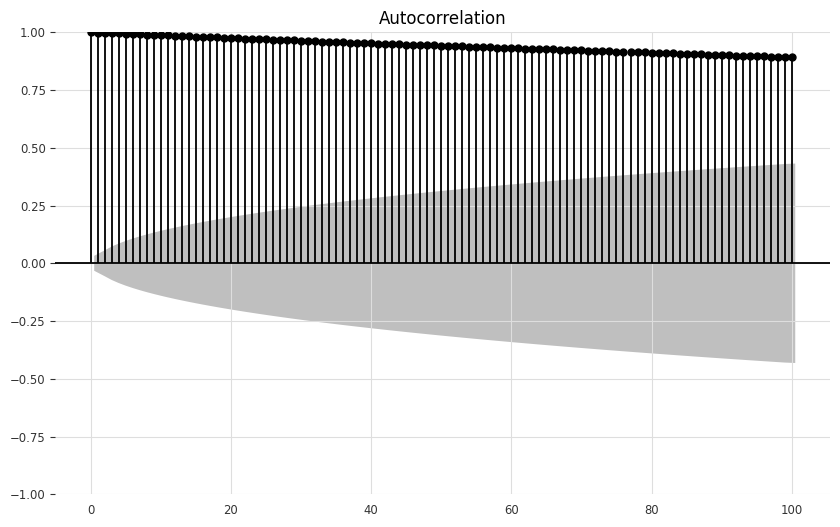

In [ ]:
# Plot the autocorrelation function (ACF) for the time series data
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['Close'], lags = 100, ax = ax)  # Generate the ACF plot with 100 lags
plt.show()

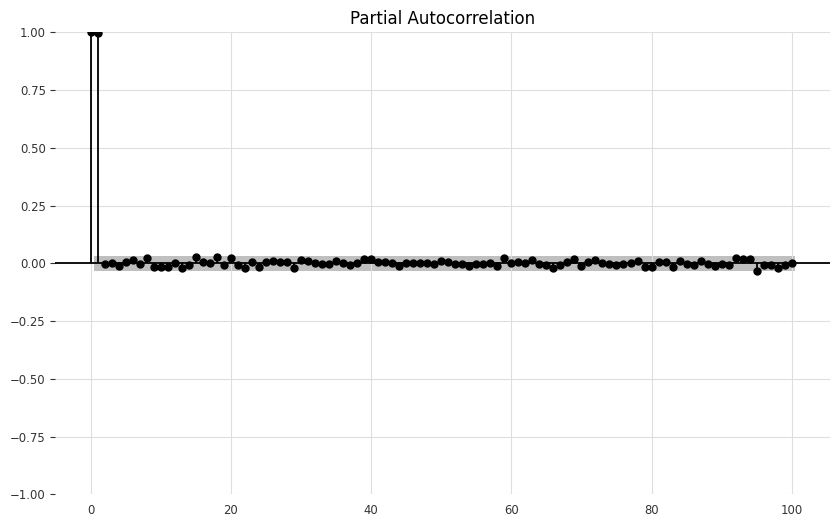

In [ ]:
# Plot the partial autocorrelation function (PACF) for the time series data
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['Close'], lags = 100, ax = ax)  # Generate the PACF plot with 100 lags
plt.show()

# Time Series, Time, Static Variables

In [ ]:
# Prepare a TimeSeries object from the dataframe
series = TimeSeries.from_dataframe(df,
                                   value_cols = "Close",
                                   # static_covariates = none
                                   )

# Display the TimeSeries object
series

<TimeSeries (DataArray) (Datetime: 3654, component: 1, sample: 1)> Size: 29kB
array([[[157.659]],

       [[157.564]],

       [[157.499]],

       ...,

       [[143.899]],

       [[144.064]],

       [[143.896]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 29kB 2025-01-02T18:00:00 ... 2025-06...
  * component  (component) <U5 20B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
# Function to encode the year as a normalized value
def encode_year(idx):
  return (idx.year - 2000) / 50

# Set up the add_encoders dictionary to specify how different time-related encoders and transformers should be applied
add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week','month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week','month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'Etc/GMT-2'
}

# Past Covariates

In [ ]:
X_past = df.iloc[:,4:12]
# Convert the isolated past covariates into a TimeSeries object
past_covariates = TimeSeries.from_dataframe(X_past)
# Display
past_covariates

<TimeSeries (DataArray) (Datetime: 3654, component: 8, sample: 1)> Size: 234kB
array([[[3.81600000e+03],
        [4.00000000e+00],
        [1.57129900e+02],
        ...,
        [9.31245225e+01],
        [6.90211061e+01],
        [1.00000000e+00]],

       [[3.53500000e+03],
        [4.00000000e+00],
        [1.57155050e+02],
        ...,
        [7.98295455e+01],
        [7.97280632e+01],
        [1.00000000e+00]],

       [[2.95500000e+03],
        [4.00000000e+00],
        [1.57167100e+02],
        ...,
...
        ...,
        [8.65423051e+01],
        [8.67865867e+01],
        [1.00000000e+00]],

       [[2.49100000e+03],
        [1.30000000e+01],
        [1.43290350e+02],
        ...,
        [9.75349767e+01],
        [8.88518765e+01],
        [1.00000000e+00]],

       [[1.26400000e+03],
        [1.30000000e+01],
        [1.43350150e+02],
        ...,
        [8.63424384e+01],
        [9.01399067e+01],
        [1.00000000e+00]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 29kB 2025-01-02T18:00:00 ... 2025-06...
  * component  (component) <U10 320B 'Tickvol' 'Spread' ... '%D' 'Supertrend'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# Future Covariates

In [ ]:
X_future = df.iloc[:,12:]
future_covariates = TimeSeries.from_dataframe(X_future)
future_covariates

<TimeSeries (DataArray) (Datetime: 3654, component: 4, sample: 1)> Size: 117kB
array([[[ 0.],
        [18.],
        [ 3.],
        [ 1.]],

       [[ 0.],
        [19.],
        [ 3.],
        [ 1.]],

       [[ 0.],
        [20.],
        [ 3.],
        [ 1.]],

       ...,

       [[ 0.],
        [21.],
        [ 1.],
        [ 1.]],

       [[ 0.],
        [22.],
        [ 1.],
        [ 1.]],

       [[ 0.],
        [23.],
        [ 1.],
        [ 1.]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 29kB 2025-01-02T18:00:00 ... 2025-06...
  * component  (component) <U14 224B 'is_nfp' 'hour' 'weekday' 'is_market_open'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# Scaling

In [ ]:
# Import the Scaler class and initialize two instances of it
scaler1 = Scaler()
scaler2 = Scaler()

In [ ]:
# Apply the scaler1 to the time series
y_transformed = scaler1.fit_transform(series)

In [ ]:
# Apply the scaler2 to the past and future covariates
past_covariates_transformed = scaler2.fit_transform(past_covariates)
future_covariates_transformed = scaler2.fit_transform(future_covariates)

# TFT Model

In [ ]:
# Set the forecasting horizon
forecasting_horizon = 24

In [ ]:
# Build and configure the TFT (Temporal Fusion Transformer) model
model = TFTModel(
    input_chunk_length=96,  # Number of time steps in the input sequence
    output_chunk_length=forecasting_horizon,  # Number of time steps to predict
    hidden_size=16,  # Number of hidden units in the model
    lstm_layers=2,  # Number of LSTM layers
    num_attention_heads=4,  # Number of attention heads in the attention mechanism
    dropout=0.1,  # Dropout rate to prevent overfitting
    batch_size=64,  # Batch size for training
    n_epochs=10,  # Number of epochs for training
    add_encoders=add_encoders,  # Encoders configuration for the model
    use_static_covariates=True,  # Whether to use static covariates
    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}  # Trainer configuration for using GPU
)

# Fit the model to the time series data with past and future covariates
model.fit(
    y_transformed,
    past_covariates=past_covariates_transformed,
    future_covariates=future_covariates_transformed
)


Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=96, output_chunk_length=24, batch_size=64, n_epochs=10, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

# Cross-Validation

In [ ]:
# Perform cross-validation with rolling forecast using the TFT model
cv = model.historical_forecasts(
    series=y_transformed,
    past_covariates=past_covariates_transformed,
    future_covariates=future_covariates_transformed,
    forecast_horizon=forecasting_horizon,  # Number of time steps to forecast
    start=df.shape[0] - 10 * forecasting_horizon,  # Start point for the rolling forecast
    retrain=True,  # Whether to retrain the model at each step
    stride=forecasting_horizon,  # Number of time steps to move forward for each forecast
    last_points_only=False  # Whether to include only the last points in each rolling window
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Initialize a list to store RMSE values for each cross-validation fold
rmse_cv = []

# Iterate over each fold in the cross-validation results
for i in range(len(cv)):
    # Inverse transform the predictions to original scale
    inv_pred = scaler1.inverse_transform(cv[i])

    # Convert the TimeSeries object to pandas Series
    predictions = inv_pred.to_series()

    # Extract the corresponding actual values
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.Close[start:end]

    # Compute the RMSE for the current fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)

# Print the average RMSE across all folds
print(f"The CV error is {np.mean(rmse_cv)}")

# Print the list of RMSE values for each fold
print(f"Here is the list of errors {rmse_cv}")


The CV error is 1.1958278305229457
Here is the list of errors [1.038139839376729, 1.3454333383158552, 1.923178226017313, 0.8309059512371091, 1.4653941430718282, 0.7363509803207557, 0.9679518018015921, 0.9596477841327612, 1.3490278983862376, 1.3422483425692773]


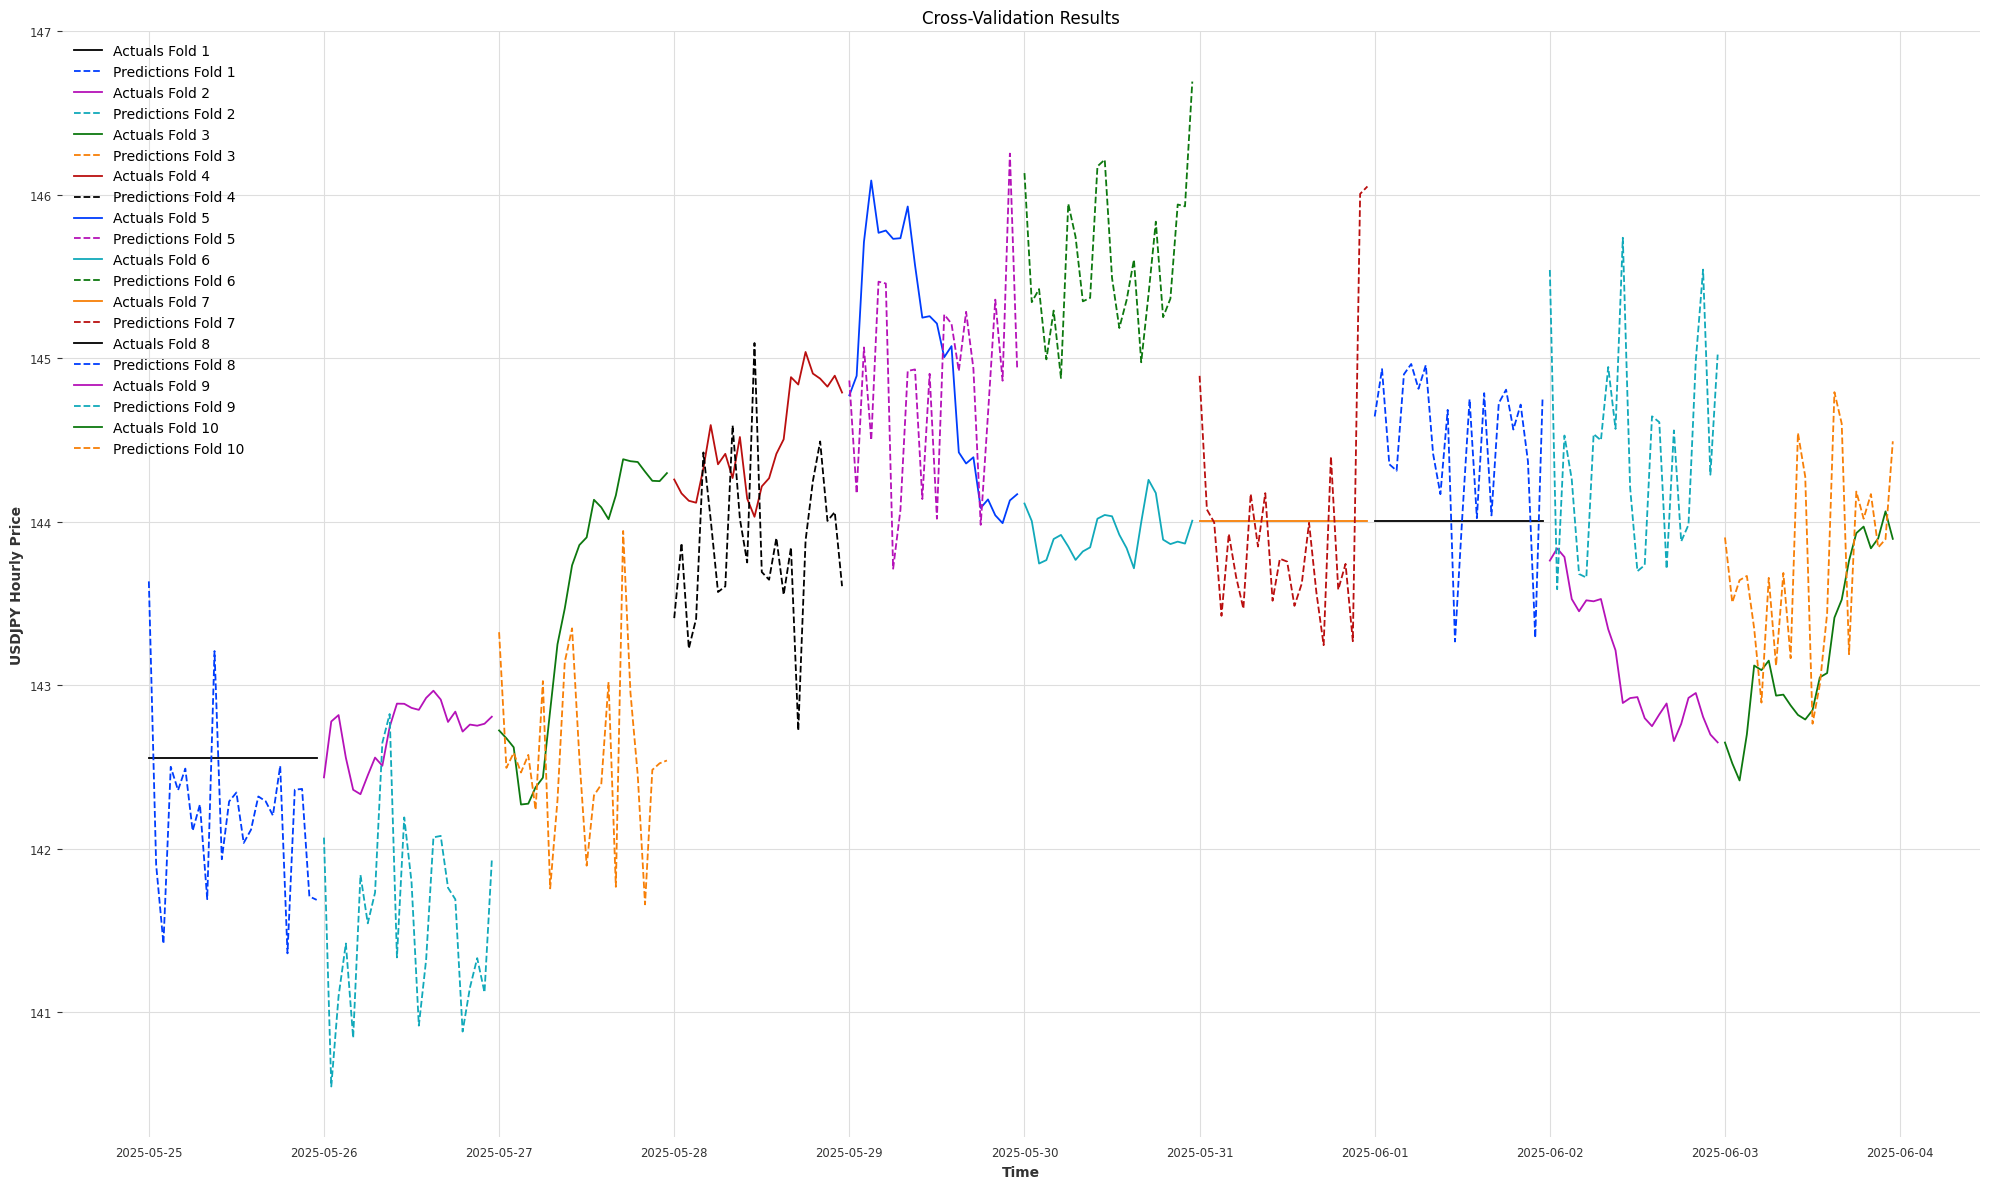

In [ ]:
# Set the figure size for the plot
fig, ax = plt.subplots(figsize=(20, 12))

# Plot predictions and actual values for each cross-validation fold
for i in range(len(cv)):
    # Inverse transform predictions to original scale
    inv_pred = scaler1.inverse_transform(cv[i])

    # Convert TimeSeries to pandas Series
    predictions = inv_pred.to_series()

    # Extract the corresponding actual values from original dataframe
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.Close[start:end]

    # Plot actual values and predictions
    ax.plot(actuals, label=f"Actuals Fold {i+1}")
    ax.plot(predictions, label=f"Predictions Fold {i+1}", linestyle='dashed')

# Set labels and title for the plot
ax.set_xlabel("Time")
ax.set_ylabel("USDJPY Hourly Price")
ax.set_title("Cross-Validation Results")
ax.legend()
plt.tight_layout()
plt.show()


# Parameter Tuning

In [ ]:
from sklearn.model_selection import ParameterSampler
# Parameter Grid
param_grid = {
    'input_chunk_length': [48,96, 172],
    'output_chunk_length': [24],
    'hidden_size': [8, 16, 24],
    'num_attention_heads': [2,4,6],
    'dropout': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128],
    'lstm_layers': [1,2,4],
    'n_epochs': [5,10,20]
}

In [ ]:
# Number of parameter combinations to try
n_iter = 10

# Generate a list of parameter combinations to sample from the parameter grid
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=1502))

# Duplicate the parameter list for further use or comparison
param_list2 = param_list

# Print the list of parameter combinations
print(param_list)

[{'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 128}, {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 48, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 64}, {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 4, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 32}, {'output_chunk_length': 24, 'num_attention_heads': 2, 'n_epochs': 10, 'lstm_layers': 2, 'input_chunk_length': 96, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 32}, {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 1, 'input_chunk_length': 172, 'hidden_size': 24, 'dropout': 0.1, 'batch_size': 64}, {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 5, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size'

In [ ]:
# Define fixed parameters that will be used across all configurations
fixed_params = {
    'use_static_covariates': True,
    'add_encoders': add_encoders,
    'pl_trainer_kwargs': {'accelerator': 'gpu', "devices": [0]},
}

# Update each parameter set in the list with the fixed parameters
for params in param_list:
  params.update(fixed_params)

In [ ]:
# Initialize a list to store RMSE values for each set of parameters
rmse = []

# Iterate over each set of parameter combinations
for params in param_list:
    # Build the TFT model using the current set of parameters
    model = TFTModel(**params)

    # Perform cross-validation with rolling forecast
    cv = model.historical_forecasts(
        series=y_transformed,
        past_covariates=past_covariates_transformed,
        future_covariates=future_covariates_transformed,
        forecast_horizon=forecasting_horizon,
        start=df.shape[0] - 10 * forecasting_horizon,
        retrain=True,
        stride=forecasting_horizon,
        last_points_only=False
    )

    # Initialize a list to store RMSE values for each fold
    rmse_cv = []

    # Evaluate each fold
    for i in range(len(cv)):
        # Inverse transform predictions to original scale
        inv_pred = scaler1.inverse_transform(cv[i])

        # Convert to pandas Series
        predictions = inv_pred.to_series()

        # Extract the corresponding actual values
        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df['Close'][start:end]  # Ensure 'y' is the correct column name

        # Compute RMSE for current fold
        error_cv = np.sqrt(mean_squared_error(actuals, predictions))
        rmse_cv.append(error_cv)

    # Compute the average RMSE for the current parameter set
    avg_rmse = np.mean(rmse_cv)
    rmse.append(avg_rmse)

    # Log tested parameters and corresponding RMSE
    print(f"Tested parameters: {params} => RMSE: {avg_rmse:.4f}")

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 128, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 3.3092


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 48, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 1.6110


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 4, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 1.3922


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 2, 'n_epochs': 10, 'lstm_layers': 2, 'input_chunk_length': 96, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 1.2365


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 1, 'input_chunk_length': 172, 'hidden_size': 24, 'dropout': 0.1, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 1.0038


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 5, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 3.4632


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 4, 'input_chunk_length': 96, 'hidden_size': 16, 'dropout': 0.3, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 0.8509


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 2, 'n_epochs': 10, 'lstm_layers': 2, 'input_chunk_length': 172, 'hidden_size': 16, 'dropout': 0.2, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 1.4310


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 20, 'lstm_layers': 1, 'input_chunk_length': 48, 'hidden_size': 8, 'dropout': 0.2, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 1.5388


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 2, 'input_chunk_length': 96, 'hidden_size': 16, 'dropout': 0.2, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE: 1.0471


In [ ]:
# Create a DataFrame and add the RMSE values
results_df = pd.DataFrame(param_list2)
results_df['rmse'] = rmse
results_df

,output_chunk_length,num_attention_heads,n_epochs,lstm_layers,input_chunk_length,hidden_size,dropout,batch_size,use_static_covariates,add_encoders,pl_trainer_kwargs,rmse
0,24,6,10,1,96,8,0.1,128,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",3.309241
1,24,4,10,1,48,24,0.2,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",1.611036
2,24,4,10,4,96,8,0.1,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",1.392223
3,24,2,10,2,96,24,0.2,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",1.236505
4,24,6,20,1,172,24,0.1,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",1.003767
5,24,4,5,1,96,8,0.1,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",3.463213
6,24,6,20,4,96,16,0.3,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",0.850858
7,24,2,10,2,172,16,0.2,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",1.431014
8,24,4,20,1,48,8,0.2,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",1.538833
9,24,6,20,2,96,16,0.2,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",1.047090


In [ ]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = results_df[results_df['rmse'] == results_df['rmse'].min()]
best_params.to_csv('best_params.csv')

# Predict the Future

In [ ]:
# Load the best parameters from the CSV file, and put it in a dictionary
best_params = pd.read_csv('best_params.csv', index_col =0).drop(columns = "rmse")
best_params_dict = best_params.squeeze().to_dict()
best_params_dict

{'output_chunk_length': 24,
 'num_attention_heads': 6,
 'n_epochs': 20,
 'lstm_layers': 4,
 'input_chunk_length': 96,
 'hidden_size': 16,
 'dropout': 0.3,
 'batch_size': 32,
 'use_static_covariates': True,
 'add_encoders': "{'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}",
 'pl_trainer_kwargs': "{'accelerator': 'gpu', 'devices': [0]}"}

In [ ]:
# List of parameters that should be converted to integers
int_params = ['input_chunk_length', 'output_chunk_length',
              'hidden_size', 'num_attention_heads', 'batch_size',
              'lstm_layers', 'n_epochs']

# Convert specified float parameters to integers
for key in int_params:
  best_params_dict[key] = int(best_params_dict[key])

In [ ]:
# Update the best parameters dictionary with the fixed parameters
best_params_dict.update(fixed_params)
best_params_dict

{'output_chunk_length': 24,
 'num_attention_heads': 6,
 'n_epochs': 20,
 'lstm_layers': 4,
 'input_chunk_length': 96,
 'hidden_size': 16,
 'dropout': 0.3,
 'batch_size': 32,
 'use_static_covariates': True,
 'add_encoders': {'cyclic': {'future': ['hour',
    'day',
    'dayofweek',
    'week',
    'month']},
  'datetime_attribute': {'future': ['hour',
    'day',
    'dayofweek',
    'week',
    'month']},
  'position': {'past': ['relative'], 'future': ['relative']},
  'custom': {'past': [<function __main__.encode_year(idx)>],
   'future': [<function __main__.encode_year(idx)>]},
  'transformer': Scaler,
  'tz': 'Etc/GMT-2'},
 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}}

In [ ]:
# Build the TFT model using the best-tuned parameters
tuned_model = TFTModel(**best_params_dict)

# Fit the tuned model
tuned_model.fit(y_transformed,
                past_covariates = past_covariates_transformed,
                future_covariates = future_covariates_transformed)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=4, num_attention_heads=6, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.3, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, output_chunk_length=24, n_epochs=20, input_chunk_length=96, batch_size=32, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x79bf5083e480>], 'future': [<function encode_year at 0x79bf5083e480>]}, 'transformer': Scaler, 'tz': 'Etc/GMT-2'}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [109]:
# Generate forecasts for the future using the tuned model
forecast = tuned_model.predict(
    n=forecasting_horizon,
    series=y_transformed,
    past_covariates=past_covariates_transformed,
    future_covariates=future_covariates_transformed
)

# Inverse transform and convert to pandas Series
forecast = scaler1.inverse_transform(forecast).pd_series().rename("TFT")

# Display the forecasted values
forecast


Predicting: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'TimeSeries' object has no attribute 'pd_series'

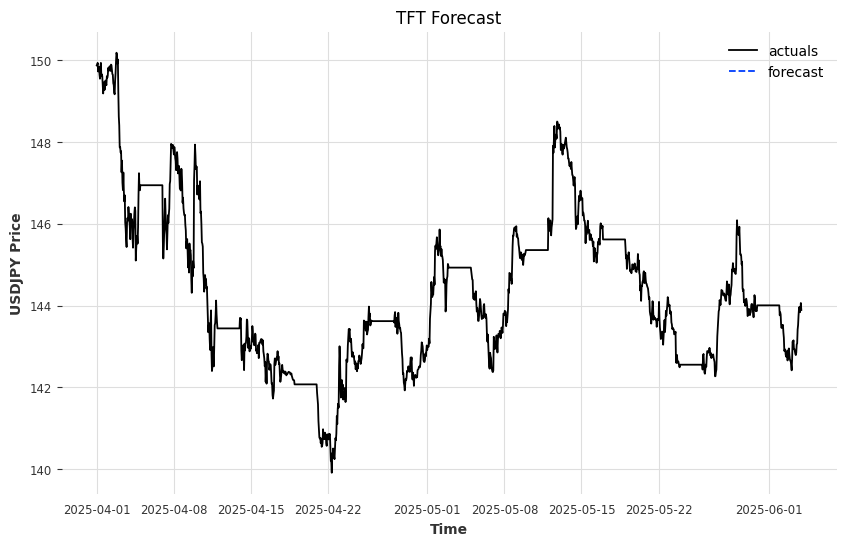

In [107]:
# Extract forecast values and time index
forecast_values = forecast.values()
forecast_time = forecast.time_index

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual values from June 2025 onwards
ax.plot(df.Close['2025-04':], label="actuals")

# Plot forecasted values
ax.plot(forecast_time, forecast_values, label="forecast", linestyle='dashed')

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("USDJPY Price")
ax.set_title("TFT Forecast")
ax.legend()
plt.show()


# Interpretability

In [ ]:
from darts.explainability import TFTExplainer
# Build the explainer for the tuned TFT model
explainer = TFTExplainer(tuned_model)
# Generate explainability results for the model
explainability_result = explainer.explain()

Predicting: |          | 0/? [00:00<?, ?it/s]

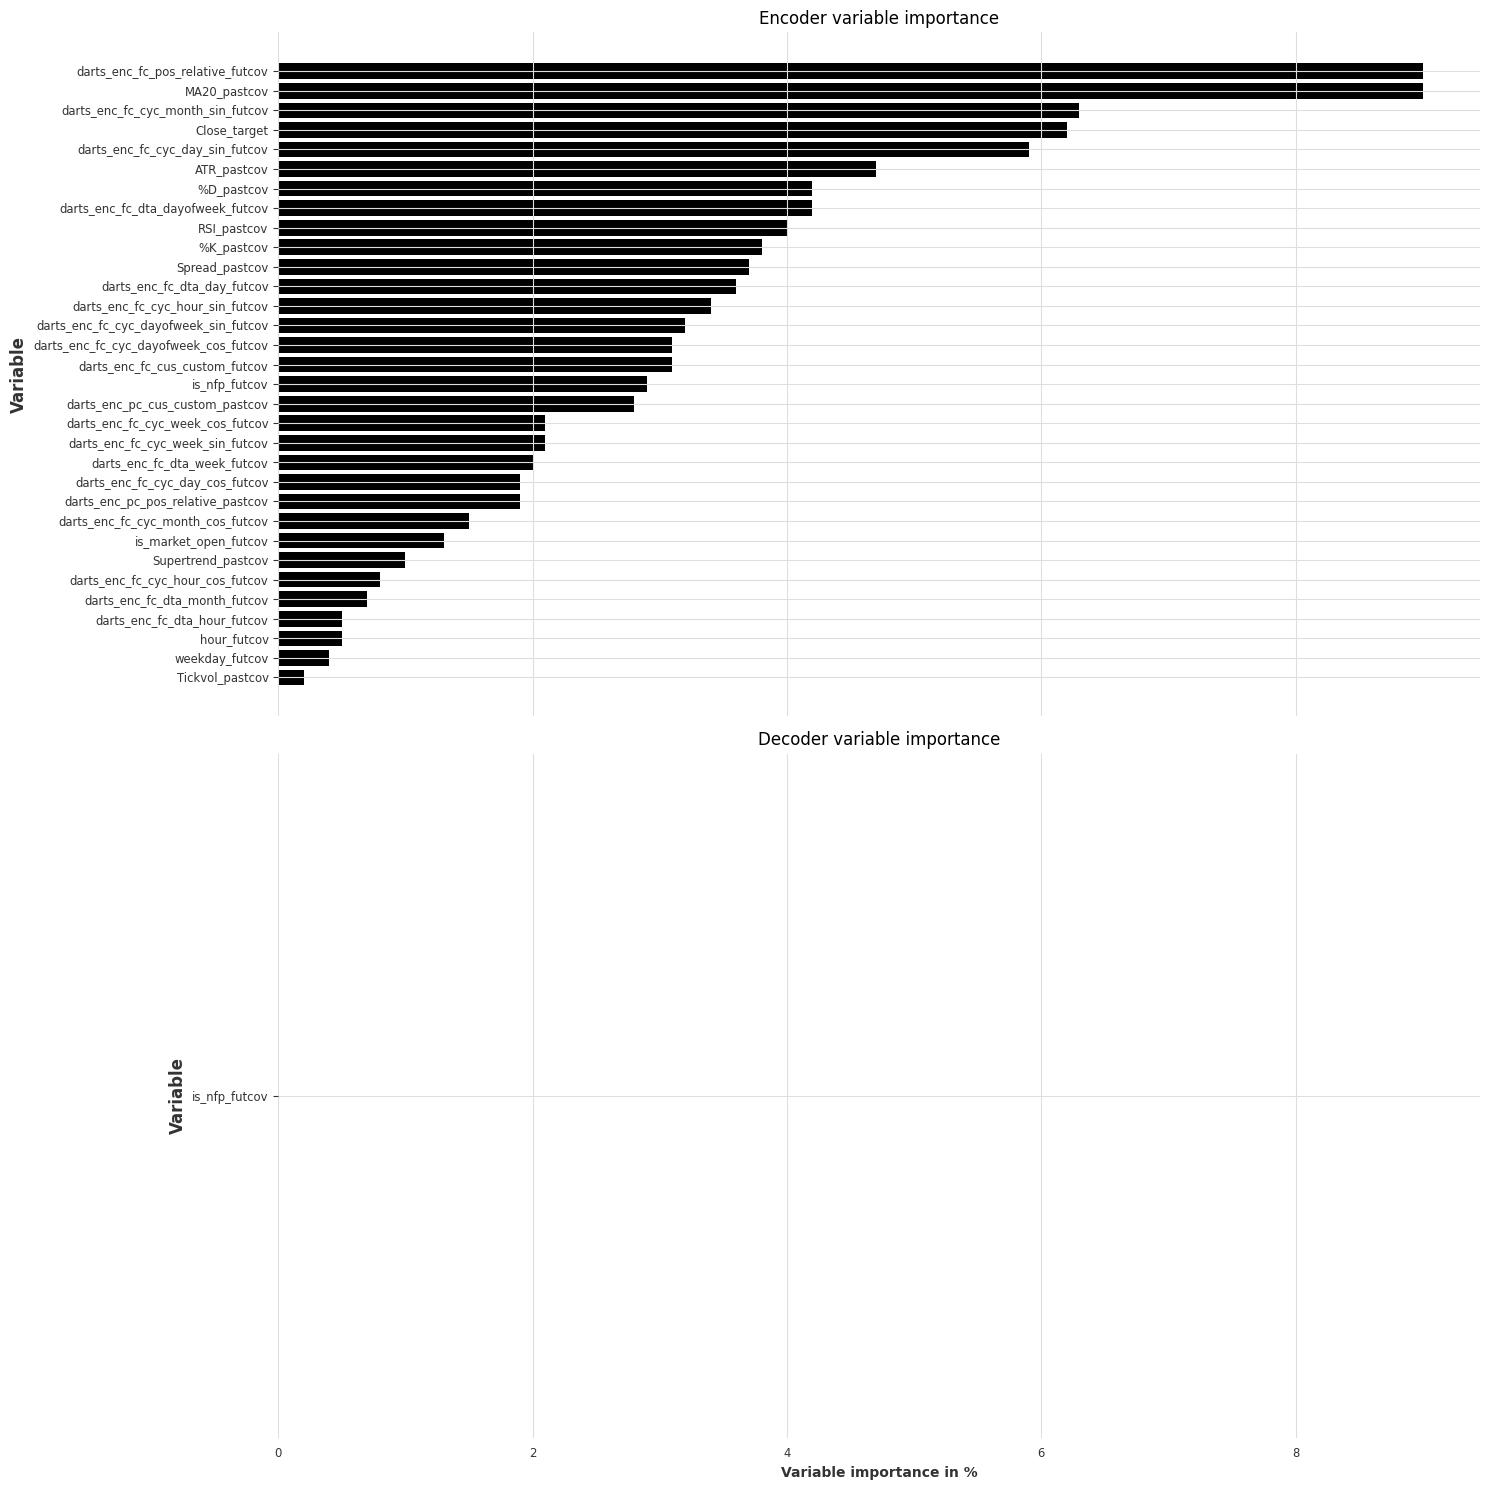

In [ ]:
# Plot the variable importance based on the explainability results
explainer.plot_variable_selection(explainability_result, fig_size = (15,15))

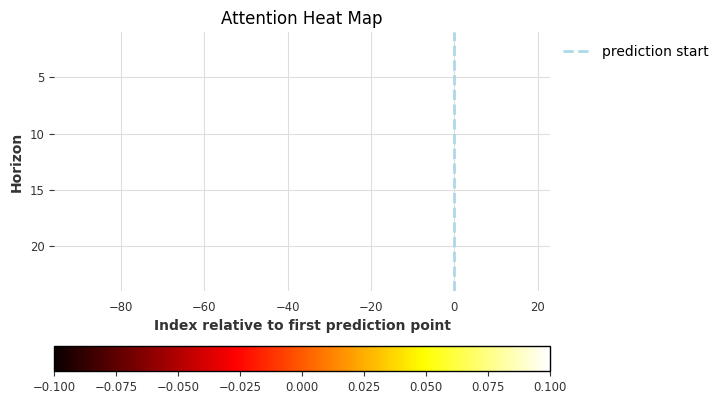

<Axes: title={'center': 'Attention Heat Map'}, xlabel='Index relative to first prediction point', ylabel='Horizon'>

In [ ]:
# Plot the attention mechanism for the model
explainer.plot_attention(explainability_result, plot_type = "heatmap")

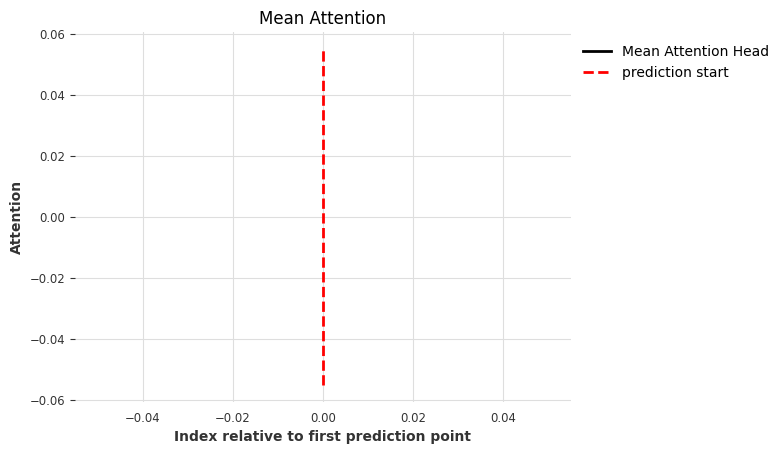

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [ ]:
# Plot the attention mechanism for the model
explainer.plot_attention(explainability_result, plot_type = "time")